In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.stats import bayesian_blocks

import cosmology
from hbtp import HBTReader

from src import read

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
savefig = False

In [3]:
plt.style.use('paper')

### Analysis parameters

In [4]:
grav = "GR_b64n512"
prof = "nfw"
snap = 122
NFW_f = 0.02
bin = 3

# r = HBTReader("./data/%s/subcat" % grav)

zs = pd.read_csv(
    "./data/redshift_list.txt", delimiter=" ", header=None, names=["snap", "z"]
).set_index("snap")

### Halo mass function & binning

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [5]:
def read_haloes(grav, snap):
    hs = HBTReader("./data/%s/subcat" % grav).LoadHostHalos(snap)
    hs["M200Crit"] = 1e10 * hs["M200Crit"]
    hs = hs[hs["M200Crit"] >= 1000 * 1.52315180e8]
    #     hs = hs[hs["CenterOffset"] >= 0.07]
    return hs


def bin_haloes(haloes, bin_column, bin_edges, bin_transform=lambda x: x):
    hs = np.lib.recfunctions.append_fields(
        haloes,
        "bin",
        np.digitize(bin_transform(haloes[bin_column]), bin_edges, right=True),
        usemask=False,
    )
    hs = hs[hs["bin"] != 0]
    return hs


def halo_mass_function(haloes, edges=20):
    if edges == "bayes":
        bin_edges = bayesian_blocks(np.log10(haloes["M200Crit"]))
    bin_counts, bin_edges = np.histogram(np.log10(haloes["M200Crit"]), edges)
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    haloes = bin_haloes(haloes, "M200Crit", bin_edges, lambda x: np.log10(x))
    nbins = bin_centres.size
    #     for _b in range(1, nbins + 1):
    #         print(
    #             "%d:\t%.2f < %.2f < %.2f\t%s"
    #             % (
    #                 _b,
    #                 bin_edges[_b - 1],
    #                 bin_centres[_b - 1],
    #                 bin_edges[_b],
    #                 "(current)" if bin == _b else "",
    #             )
    #         )
    return bin_centres, np.log10(bin_counts / (64 ** 3) / 0.15), bin_edges

In [6]:
hs = read_haloes(grav, snap)

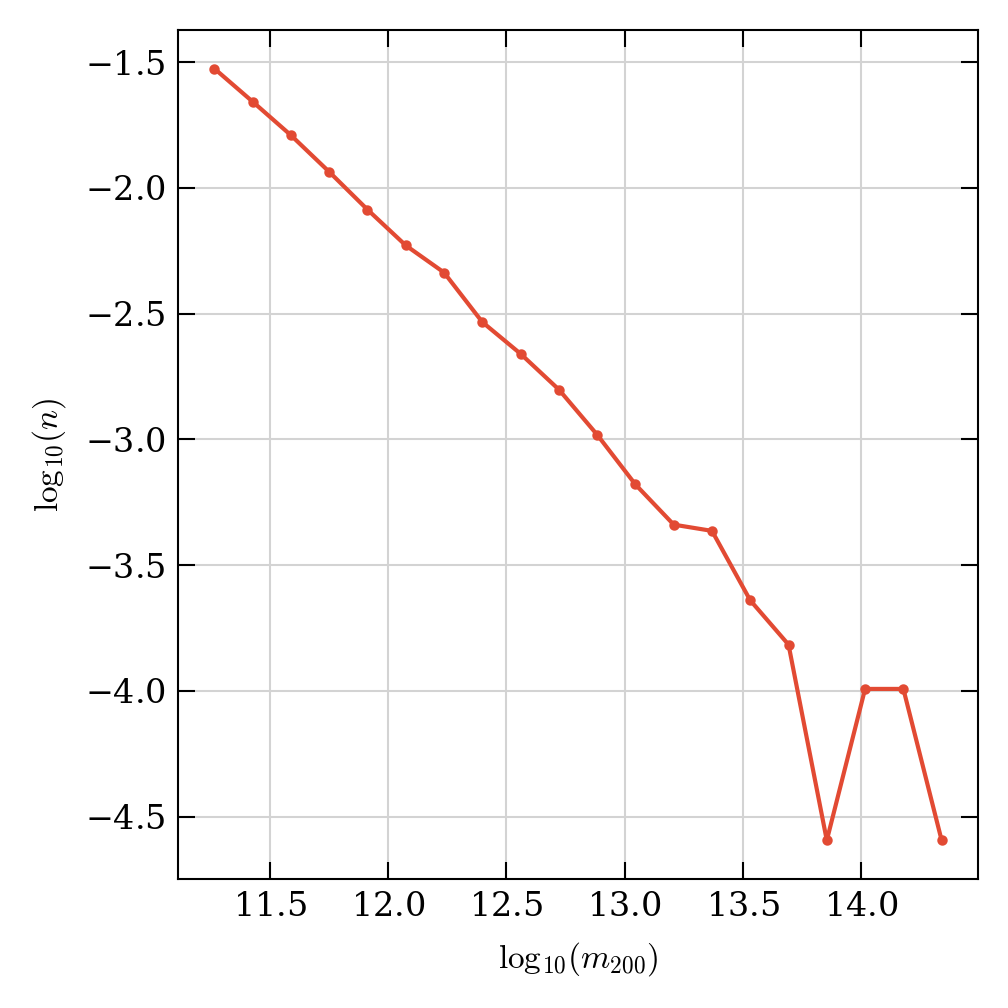

In [7]:
fig, ax = plt.subplots(1)
ax.set_xlabel(r"$\log_{10}(m_{200})$")
ax.set_ylabel(r"$\log_{10}(n)$")

ax.plot(*halo_mass_function(hs)[0:2], color="C0", marker=".", zorder=1)

fig.tight_layout()

if savefig:
    fig.savefig("./plots/mf.pdf")

In [8]:
bin_counts, bin_edges = np.histogram(np.log10(hs["M200Crit"]), 20)
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
hs = bin_haloes(hs, 'M200Crit', bin_edges, lambda x: np.log10(x))
nbins = bin_centres.size

In [9]:
hs = hs[hs["bin"] == bin]

### $m^*$ calculation

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


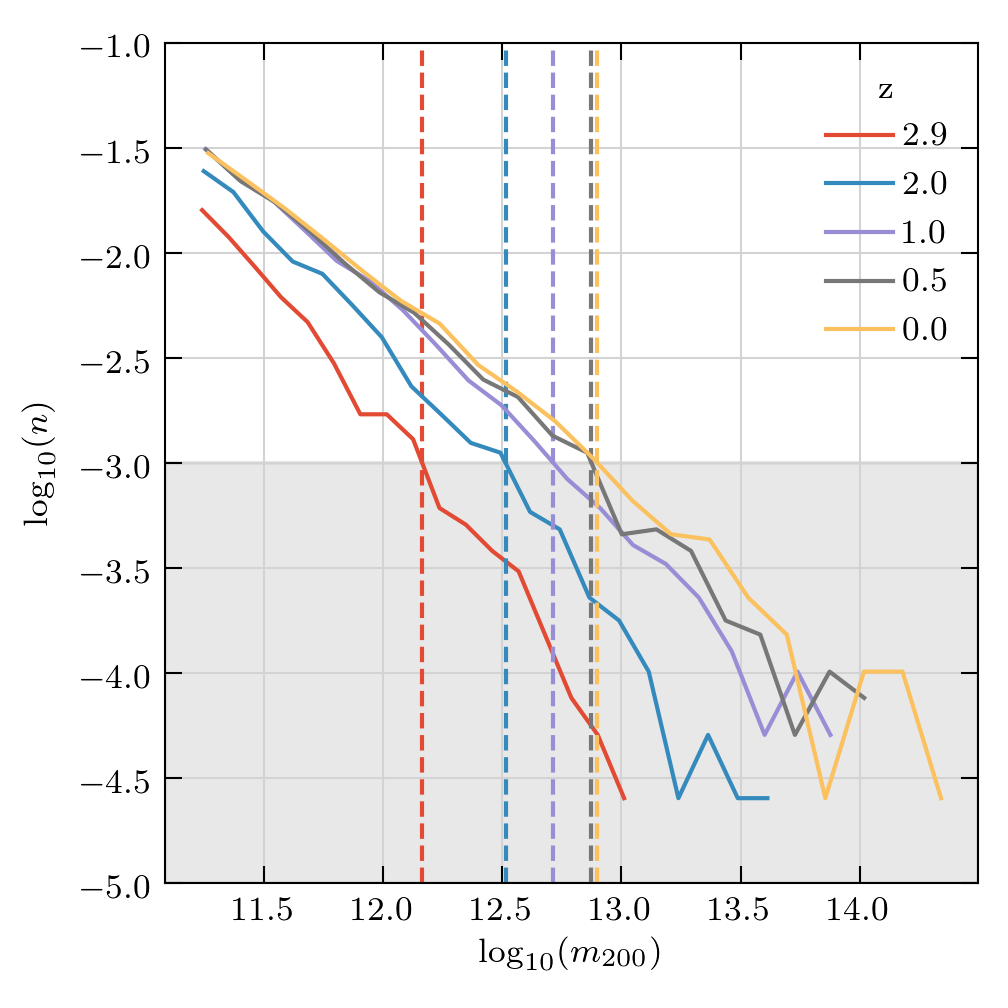

In [10]:
fig, ax = plt.subplots(1)
ax.set_xlabel(r"$\log_{10}(m_{200})$")
ax.set_ylabel(r"$\log_{10}(n)$")

n_star = -3.0
m_star = []
m_star_bin = []
ax.axhspan(-5.0, n_star, color="lightgrey", alpha=0.5)

for i, _snap in enumerate([51, 61, 78, 93, 122]):
    x_k, y_k, bin_edges = halo_mass_function(read_haloes(grav, _snap))

    y1, y2 = y_k[y_k > n_star][-1], y_k[y_k < n_star][0]
    x1, x2 = x_k[y_k > n_star][-1], x_k[y_k < n_star][0]

    m_star.append(((x2 - x1) / (y2 - y1)) * (n_star - y1) + x1)
    m_star_bin.append(np.digitize(m_star[i], bin_edges))

    ax.plot(x_k, y_k, "C%d" % i, label="%.1f" % (zs.loc[_snap].values[0]))
    ax.axvline(m_star[i], ls="--", color="C%d" % i)

ax.legend(title="z")
ax.set_ylim([-5.0, -1.0])

fig.tight_layout()

if savefig:
    fig.savefig("./plots/mstar.pdf")

Health check: is $m^{*}$ following $(1+z)^2$ relation?

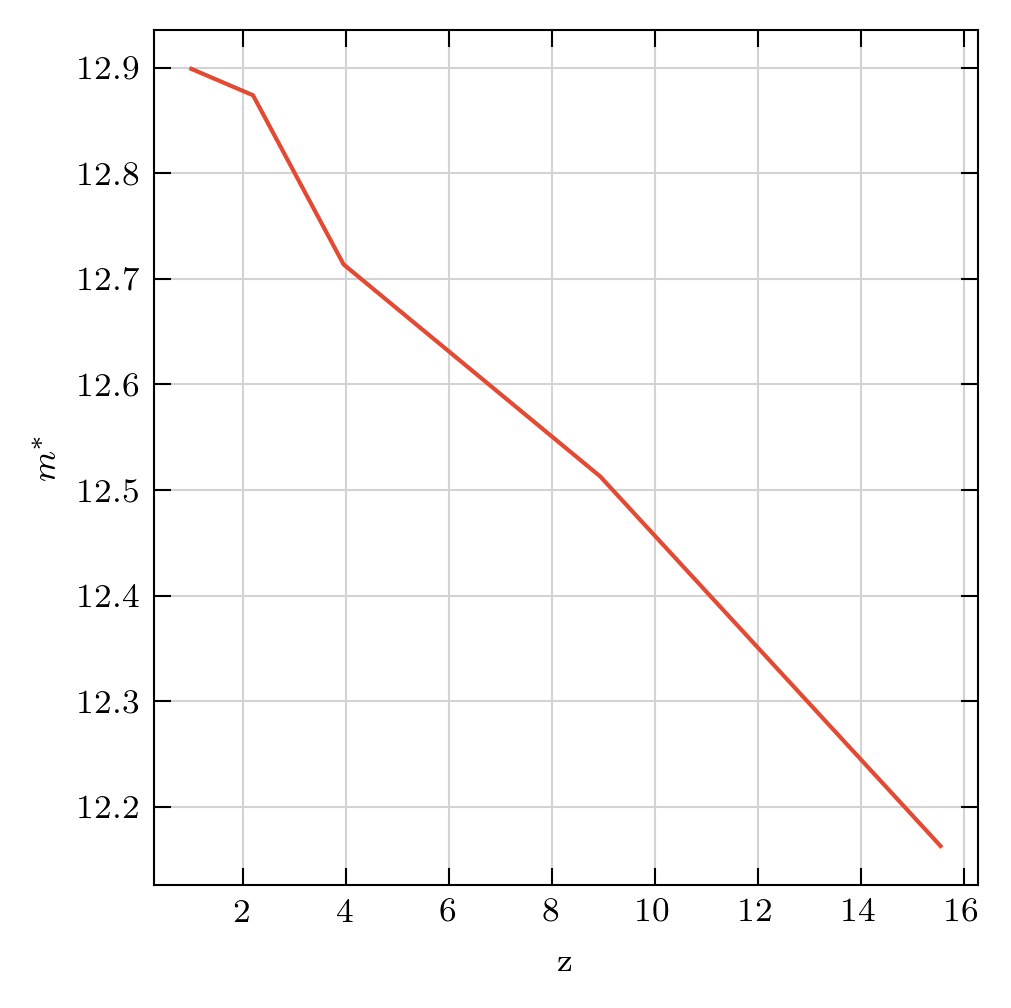

In [11]:
plt.plot([(1.0 + z) ** 2.0 for z in zs.loc[[51, 61, 78, 93, 122]].values], m_star)
plt.ylabel(r"$m^{*}$")
plt.xlabel("z")

plt.tight_layout()

### Density profile

In [12]:
def halo_profiles(hs, prof):
    ps = hs["Profile"]
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    if prof == "nfw":

        def f(x, c):
            return np.log10(cosmology.nfw.m(np.power(10.0, x), c))

        fit = curve_fit(
            f, x[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx], [10.0]
        )
        c = fit[0][0]

        rho_s = np.log10(cosmology.nfw.rho_enc(1.0 / c, c))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c

    elif prof == "einasto":

        def f(x, c, a):
            return np.log10(cosmology.einasto.m(np.power(10.0, x), c, a))

        fit = curve_fit(
            f,
            x[idx],
            np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx],
            [10.0, 1.0],
        )
        c, a = fit[0][0], fit[0][1]

        rho_s = np.log10(cosmology.einasto.rho_enc(1.0 / c, c, a))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c, a

    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")


c = halo_profiles(hs, prof)[5]

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


In [13]:
c

8.081622855697878

In [14]:
def fit_nfw(hs):
    ps = hs["Profile"]
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    def f(x, c):
        return np.log10(cosmology.nfw.m(np.power(10.0, x), c))

    popt, pcov = curve_fit(
        f, x[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx], [10.0]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(x[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 1 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 1 - 2 * np.log(L)

    return L, AIC, BIC, chi2, popt


def fit_einasto(hs):
    ps = hs["Profile"]
    xmin = 0.5 * np.cbrt((4.0 * np.pi) / (3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    def f(x, c, a):
        return np.log10(cosmology.einasto.m(np.power(10.0, x), c, a))

    popt, pcov = curve_fit(
        f, x[idx], np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx], [10.0, 1.0]
    )

    chi2 = np.sum(
        ((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - f(x[idx], *popt)))
        ** 2
    )
    L = np.exp(-chi2)
    AIC = 2 * 2 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 2 - 2 * np.log(L)

    return L, AIC, BIC, chi2, popt

In [15]:
fit_nfw(hs)

(0.9989682906009932,
 2.002064483954982,
 2.399959756753353,
 0.0010322419774911472,
 array([8.08162286]))

In [16]:
fit_einasto(hs)

(0.9999274152495883,
 4.000145174769624,
 4.795935720366366,
 7.258738481219128e-05,
 array([8.00224928, 0.17793779]))

In [17]:
einasto_parameters = halo_profiles(hs, "einasto")[5:]
print(einasto_parameters)

(8.002249281980893, 0.17793779431606624)


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


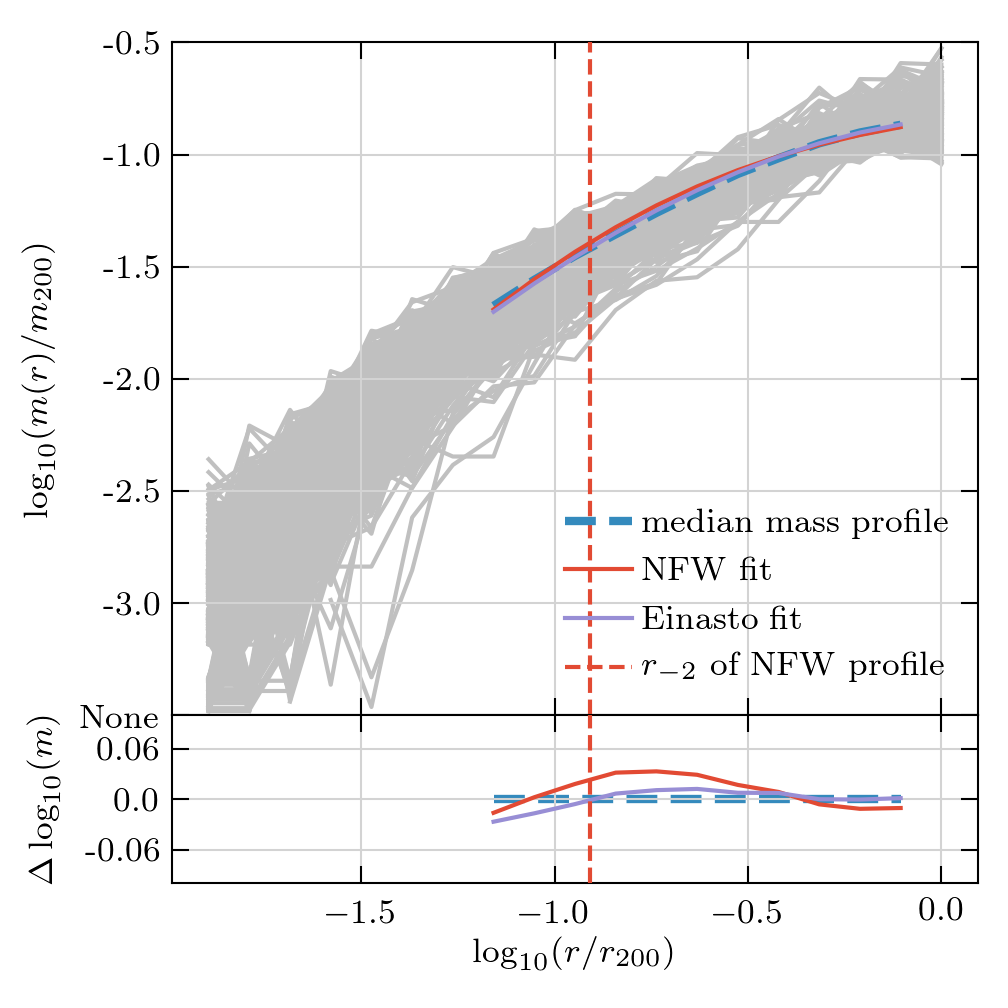

In [18]:
fig = plt.figure()
grid = plt.GridSpec(5, 1, hspace=0.0, wspace=0.0)

ax = fig.add_subplot(grid[:-1, 0])
ax.set_xlabel(None)
ax.set_ylabel(r"$\log_{10}(m(r) / m_{200})$")
ax.set_xlim([-2.1, 0.1])
ax.set_ylim([-3.5, -0.5])
ax.set_yticklabels([None, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])

ax_res = fig.add_subplot(grid[-1, 0], yticklabels=[], sharex=ax)
ax_res.set_xlabel(r"$\log_{10}(r / r_{200})$")
ax_res.set_ylabel(r"$\Delta\log_{10}(m)$")
ax_res.set_ylim([-0.1, 0.1])
ax_res.set_yticks([-0.06, 0.0, 0.06])
ax_res.set_yticklabels([-0.06, 0.0, 0.06])

if prof == "nfw":
    ps, x, p, idx, rho_s, c = halo_profiles(hs, prof)
elif prof == "einasto":
    ps, x, p, idx, rho_s, c, a = halo_profiles(hs, prof)
else:
    raise ValueError("Profile must be either 'nfw' or 'einasto'")

for _p in ps:
    ax.plot(x[1:], _p[1:], color="silver", zorder=0)
#     ax_res.plot(x[1:], (_p - p)[1:], color='silver', zorder=0)

ax.plot(
    x[idx],
    p[idx],
    color="C1",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="median mass profile",
)
ax_res.plot(
    x[idx], np.zeros_like(p[idx]), color="C1", linestyle="--", linewidth=2, zorder=1
)

ax.plot(
    x[idx],
    np.log10(cosmology.nfw.m_diff(np.power(10.0, x), c)[idx]),
    color="C0",
    linestyle="-",
    linewidth=1,
    zorder=3,
    label="NFW fit",
)
ax_res.plot(
    x[idx],
    np.log10(cosmology.nfw.m_diff(np.power(10.0, x), c)[idx]) - p[idx],
    color="C0",
    linestyle="-",
    linewidth=1,
    zorder=3,
)

ax.plot(
    x[idx],
    np.log10(cosmology.einasto.m_diff(np.power(10.0, x), *einasto_parameters)[idx]),
    color="C2",
    linestyle="-",
    linewidth=1,
    zorder=3,
    label="Einasto fit",
)
ax_res.plot(
    x[idx],
    np.log10(cosmology.einasto.m_diff(np.power(10.0, x), *einasto_parameters)[idx])
    - p[idx],
    color="C2",
    linestyle="-",
    linewidth=1,
    zorder=3,
)

ax.axvline(
    np.log10(1.0 / c),
    color="C0",
    linestyle="--",
    zorder=4,
    linewidth=1,
    label="$r_{-2}$ of NFW profile",
)
ax_res.axvline(np.log10(1.0 / c), color="C0", linestyle="--", zorder=4, linewidth=1)

ax.legend()

fig.tight_layout()

if savefig:
    fig.savefig("./plots/prof_%s_%03d_%02d.pdf" % (grav, snap, bin))

### Collapsed Mass History

In [19]:
def F(profile, *args):
    if profile == "nfw":
        c = args[0]
        return cosmology.nfw.m(1.0 / c, c)
    elif profile == "einasto":
        c, a = args
        return cosmology.einasto.m(1.0 / c, c, a)
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

In [20]:
def halo_mass_history(grav, snap, hs, F):
    ms = np.array(
        pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))
        .set_index("HaloId")
        .fillna(0.0)
        .loc[hs["HaloId"]]
        .dropna(),
        dtype=float,
    )
    ms = np.divide(ms.T, ms[:, -1]).T
    m = np.median(ms, axis=0)

    zs = read.snaps()
    rho = cosmology.rho_c(
        np.array(
            [
                zs[zs["Snapshot"] == s][0]["Redshift"]
                for s in np.arange(1 + snap - ms.shape[1], 1 + snap)
            ]
        )
    ) / cosmology.rho_c(zs[zs["Snapshot"] == snap][0]["Redshift"])

    m_f = F * m[-1]
    y1, y2 = m[m > m_f][0], m[m < m_f][-1]
    x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
    rho_f = (np.log10(x1 / x2) / np.log10(y1 / y2)) * (np.log10(m_f / y1)) + np.log10(
        x1
    )

    return ms, rho, m, rho_f

In [21]:
F(prof, c)

0.14672763578291503

In [22]:
F('einasto', *einasto_parameters)

0.14741052225234422

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


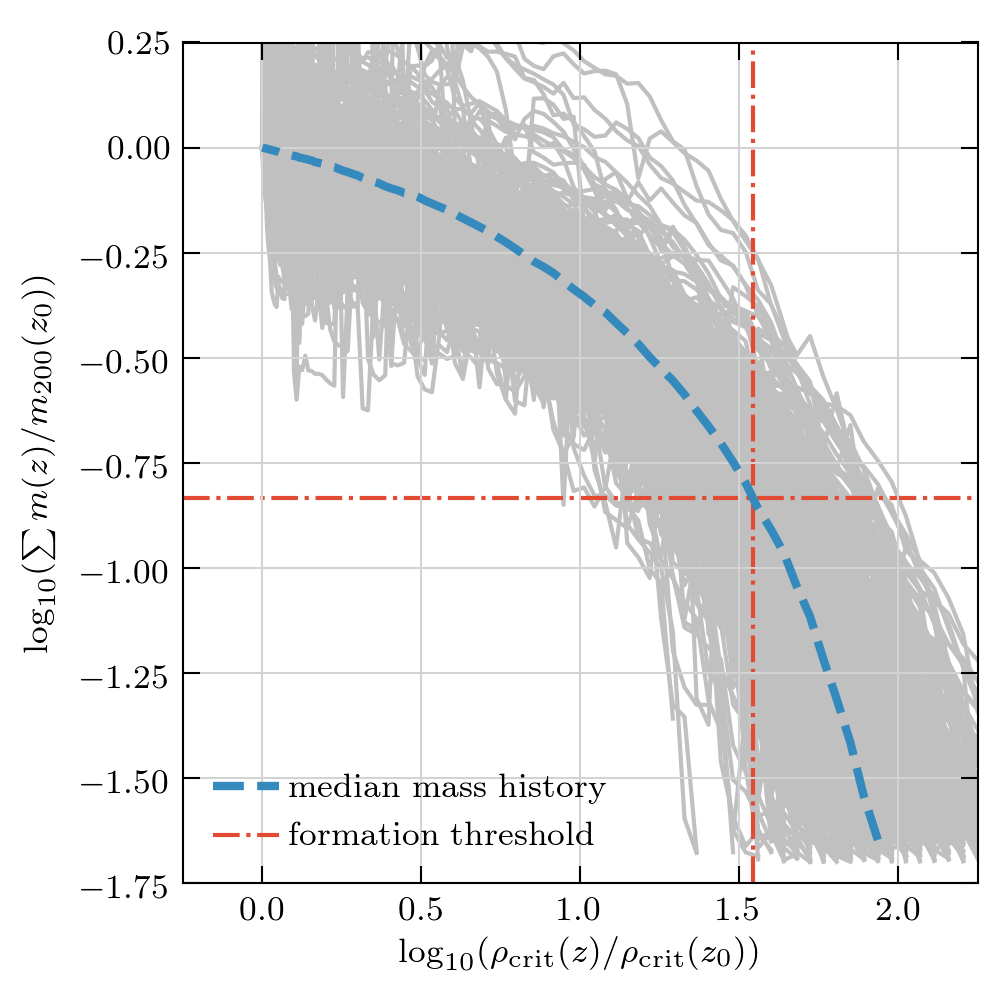

In [23]:
def plot_halo_mass_history(ax, *args):
    ms, rho, m, rho_f = args

    ax.set_xlabel(r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$")
    ax.set_ylabel(r"$\log_{10}(\sum m(z) / m_{200}(z_0))$")
    ax.set_xlim([-0.25, 2.25])
    ax.set_ylim([-1.75, 0.25])

    [ax.plot(np.log10(rho), np.log10(_), color="silver", zorder=0) for _ in ms]
    ax.plot(
        np.log10(rho),
        np.log10(m),
        color="C1",
        linestyle="--",
        linewidth=2,
        zorder=2,
        label="median mass history",
    )
    ax.axvline(
        rho_f,
        color="C0",
        linestyle="-.",
        linewidth=1,
        zorder=1,
        label="formation threshold",
    )
    ax.axhline(np.log10(F(prof, c)), color="C0", linestyle="-.", zorder=1, linewidth=1)


# def plot_analytical_mass_profile(ax, ids, snap):
#     ys = read_profiles(ids, snap)
#     ys = np.log10(
#         np.divide(
#             ys,
#             np.repeat(ys[:,-1], ys.shape[1]).reshape(ys.shape)
#         )
#     )
#     xs = np.linspace(-2.0, 0.0, ys.shape[1])

#     ax.plot(
#         np.log10(cosmology.nfw.rho_enc(np.power(10, xs), c) / 200.0) / (200.0/cosmology.rho_0),
#         np.log10(cosmology.nfw.m(np.power(10, xs), c)),
#         c="C5", linestyle="-", label="prediction"
#     )

fig, ax = plt.subplots(1)
plot_halo_mass_history(ax, *halo_mass_history(grav, snap, hs, F(prof, c)))
# plot_analytical_mass_profile(ax, list(hs["HaloId"]), snap)
ax.legend()

fig.tight_layout()

if savefig:
    fig.savefig("./plots/cmh_f%03d_%s_%03d_%02d.pdf" % (100 * NFW_f, grav, snap, bin))

### Individual mass histories

In [24]:
# fig, ax = plt.subplots(1)
# ax.set_xlabel(r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$")
# ax.set_ylabel(r"$\log_{10}(\sum m(z) / m_{200}(z_0))$")

# d = pd.read_csv("./cmh_31_8.csv")
# _x = [zs.loc[int(x), "rho"] / zs.loc[31, "rho"] for x in d.columns.values[1:]]
# _y = d.values[0][1:]
# _y = np.divide(_y.T, _y[-1]).T
# ax.plot(np.log10(_x), np.log10(_y), label="snapshot 31")

# d = pd.read_csv("./cmh_34_1.csv")
# _x = [zs.loc[int(x), "rho"] / zs.loc[34, "rho"] for x in d.columns.values[1:]]
# _y = d.values[0][1:]
# _y = np.divide(_y.T, _y[-1]).T
# ax.plot(np.log10(_x), np.log10(_y), label="snapshot 34")

# d = pd.read_csv("./cmh_70_1.csv")
# _x = [zs.loc[int(x), "rho"] / zs.loc[70, "rho"] for x in d.columns.values[1:]]
# _y = d.values[0][1:]
# _y = np.divide(_y.T, _y[-1]).T
# ax.plot(np.log10(_x), np.log10(_y), label="snapshot 70")

# ax.legend()